# QuTiPv5 Paper - Quantum Circuits with QIP

Authors: Maximilian Meyer-Mölleringhof (m.meyermoelleringhof@gmail.com), Boxi Li (etamin1201@gmail.com), Neill Lambert (nwlambert@gmail.com)

Quantum circuits serve as a standard framework for representing and manipulating quantum algorithms visually and conceptually.
As a member of the QuTiP family, the QuTiP-QIP [\[1\]](#References) package add this framework and enables several distinctive capabilities.
It allows seamless incorporation of circuit-representing unitaries into QuTiP's ecosystem using the `Qobj` class.
Moreover, it links QuTiP-QOC and the open-system solvers, enabling pulse-level simulations of circuits with realistic noise effects.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (
    about,
    basis,
    destroy,
    expect,
    ket2dm,
    mesolve,
    qeye,
    sesolve,
    sigmax,
    sigmay,
    sigmaz,
    tensor,
)
from qutip_qip.circuit import QubitCircuit
from qutip_qip.device import SCQubits

%matplotlib inline

## Introduction

In this example, we show how to

- Construct a simple quantum circuit which simulates the dynamics of a two-qubit Hamiltonian
- Simulate the dynamics of an open system, using ancillas to induce noise
- Run both simulations on hardware backend (i.e., processor) that simulates itself the intrinsic noisy dynamics

As for the Hamiltonian, we consider two interacting qubits:

$H = \dfrac{\epsilon_1}{2} \sigma_z^{(1)} + \dfrac{\epsilon_2}{2} \sigma_z^{(2)} + g \sigma_{x}^{(1)} \sigma_{x}^{(2)}$.

The Pauli matrices $\sigma_z^{(1/2)}$ describe the respective two-level system of the qubits.
The qubits are coupled via $\sigma_{x}^{(1/2)}$ and their interaction strength is given by $g$.

In [2]:
# Parameters
epsilon1 = 0.7
epsilon2 = 1.0
g = 0.3

sx1 = sigmax() & qeye(2)
sx2 = qeye(2) & sigmax()

sy1 = sigmay() & qeye(2)
sy2 = qeye(2) & sigmay()

sz1 = sigmaz() & qeye(2)
sz2 = qeye(2) & sigmaz()

H = 0.5 * epsilon1 * sz1 + 0.5 * epsilon2 * sz2 + g * sx1 * sx2

init_state = basis(2, 0) & basis(2, 1)

## Circuit Visualization

Before jumping into the example, we want to quickly look at how the circuits we build can be visualized.
In QuTiP-QIP, quantum circuits can be drawn in three different ways: as text, as matplotlib plot and in latex format.

In [3]:
qc = QubitCircuit(2, num_cbits=1)
qc.add_gate("H", 0)
qc.add_gate("H", 1)
qc.add_gate("CNOT", 1, 0)
qc.add_measurement("M", targets=[0], classical_store=0)

After this, we can draw the circuit by defining the various renderers.

        ┌───┐  ┌──────┐          
 q1 :───┤ H ├──┤ CNOT ├──────────
        └───┘  └───┬──┘          
        ┌───┐      │     ┌───┐   
 q0 :───┤ H ├──────█─────┤ M ├───
        └───┘            └─╥─┘   
                           ║     
 c0 :══════════════════════╩═════
                                 


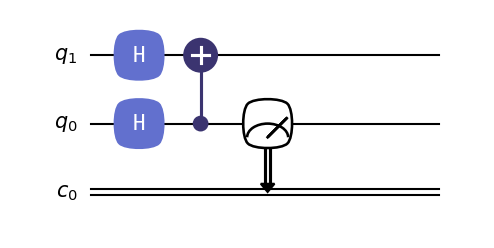

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip_qip/circuit/texrenderer.py:261: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


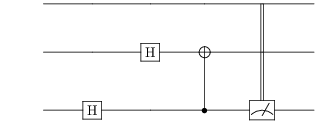

In [4]:
qc.draw("text")
qc.draw("matplotlib")
qc.draw("latex")

## Simulating Hamiltonian Dynamics

A very common method in quantum simulations is to reduce the propagation of the Schrödinger equation into several short time steps in order to finally arrive at the desired solution.
The propagator for one-time such step is well approximated by using *Trotterization*:

$\psi(t_f) = e^{-i (H_A + H_B) t_f} \psi(0) \approx [e^{-i H_A dt} e^{-i H_B dt}]^d \psi(0)$,

given that the time steps $dt = t_f / d$ is sufficiently small.
The idea then is that the Hamiltonians $H_A$ and $H_B$ are chosen such that $e^{-i H_{A,B} dt}$ can be mapped to quantum gates.

For our example, we express

$H_A = \dfrac{\epsilon_1}{2} \sigma_z^{(1)} + \dfrac{\epsilon_2}{2} \sigma_z^{(2)}$ and

$H_B = g \sigma_x^{(1)} \sigma_x^{(2)}$.

We can then construct the circuit with two qubits and a set of gates:

$A_1 = e^{-i \epsilon_1 \sigma_z^{(1)} dt / 2}$,

$A_2 = e^{-i \epsilon_2 \sigma_z^{(2)} dt / 2}$ and

$B = e^{-i g \sigma_x^{(1)} \sigma_x^{(2)} dt}$.

We apply them to an initial state and then repeat them $d$ times.

Depending on the hardware, the type of available physical gates changes.
Since we will be using a superconducting qubit hardware backend, we will express these gates in terms of RZ (rotation around Z axis), RZX (combined rotation around XZ) and Hadamard gates.
In general, QuTiP-QIP supports a great variety of gates and also the option for custom gates exists.
More information on this is presented in the original paper for QuTiP-QIP [\[1\]](#References).

Of course, the accuracy of our simulation is greatly dependent on the Trotter step size.
To keep this tutorial at a reasonable execution time, we choose $dt = 4.0$, so errors can be significant.
However it is worth exploring smaller step sizes and see the error reducing.

In [5]:
# simulation parameters
tf = 20.0  # total time
dt = 4.0  # Trotter step size
num_steps = int(tf / dt)
times_circ = np.arange(0, tf + dt, dt)

In [6]:
# initialization of two qubit circuit
trotter_simulation = QubitCircuit(2)

# gates for trotterization with small timesteps dt
trotter_simulation.add_gate("RZ", targets=[0], arg_value=(epsilon1 * dt))
trotter_simulation.add_gate("RZ", targets=[1], arg_value=(epsilon2 * dt))

trotter_simulation.add_gate("H", targets=[0])
trotter_simulation.add_gate("RZX", targets=[0, 1], arg_value=g * dt * 2)
trotter_simulation.add_gate("H", targets=[0])
trotter_simulation.compute_unitary()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-0.35032682+0.0925973j   0.        +0.j          0.        +0.j
  -0.2381743 +0.9010937j ]
 [ 0.        +0.j          0.29906676+0.20460258j -0.52626885-0.76924505j
   0.        +0.j        ]
 [ 0.        +0.j          0.52626885-0.76924505j  0.29906676-0.20460258j
   0.        +0.j        ]
 [ 0.2381743 +0.9010937j   0.        +0.j          0.        +0.j
  -0.35032682-0.0925973j ]]

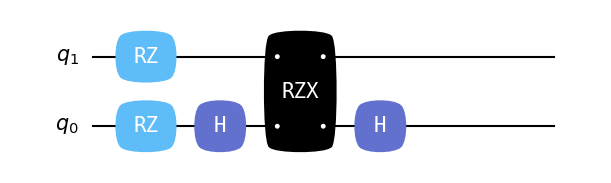

In [7]:
trotter_simulation.draw("matplotlib")

In [8]:
# Evaluate multiple iteration of a circuit
result_circ = init_state
state_trotter_circ = [init_state]

for dd in range(num_steps):
    result_circ = trotter_simulation.run(state=result_circ)
    state_trotter_circ.append(result_circ)

### Noisy Hardware

We can load our quantum circuit into a hardware backend to simulate the execution on various types of hardware.
In our case, we are interested in a superconducting circuit:

In [9]:
processor = SCQubits(num_qubits=2, t1=2e5, t2=2e5)
processor.load_circuit(trotter_simulation)
# Since SCQubit is modelled as a qutrit, we need three-level systems here
init_state_trit = tensor(basis(3, 0), basis(3, 1))

Now we can run the simulation in a similar fashion as we did before.
In this case however, the results is a `results` object from the QuTiP solver being used.
For our example, `mesolve()` is used as we specified finite $T_1$ and $T_2$ upon initialization.
The processor itself defines an internal Hamiltonian as well as available control operations, pulse shapes, $T_1$ and $T_2$, etc..

In [10]:
state_proc = init_state_trit
state_list_proc = [init_state_trit]

for dd in range(num_steps):
    result = processor.run_state(state_proc)
    state_proc = result.final_state
    state_list_proc.append(result.final_state)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


We can see the pulse shapes used in the solver:

(<Figure size 1200x600 with 8 Axes>,
 [<Axes: ylabel='$\\sigma_x^0$'>,
  <Axes: ylabel='$\\sigma_x^1$'>,
  <Axes: ylabel='$\\sigma_y^0$'>,
  <Axes: ylabel='$\\sigma_y^1$'>,
  <Axes: ylabel='$\\sigma_z^0$'>,
  <Axes: ylabel='$\\sigma_z^1$'>,
  <Axes: ylabel='$ZX^{01}$'>,
  <Axes: ylabel='$ZX^{10}$'>])

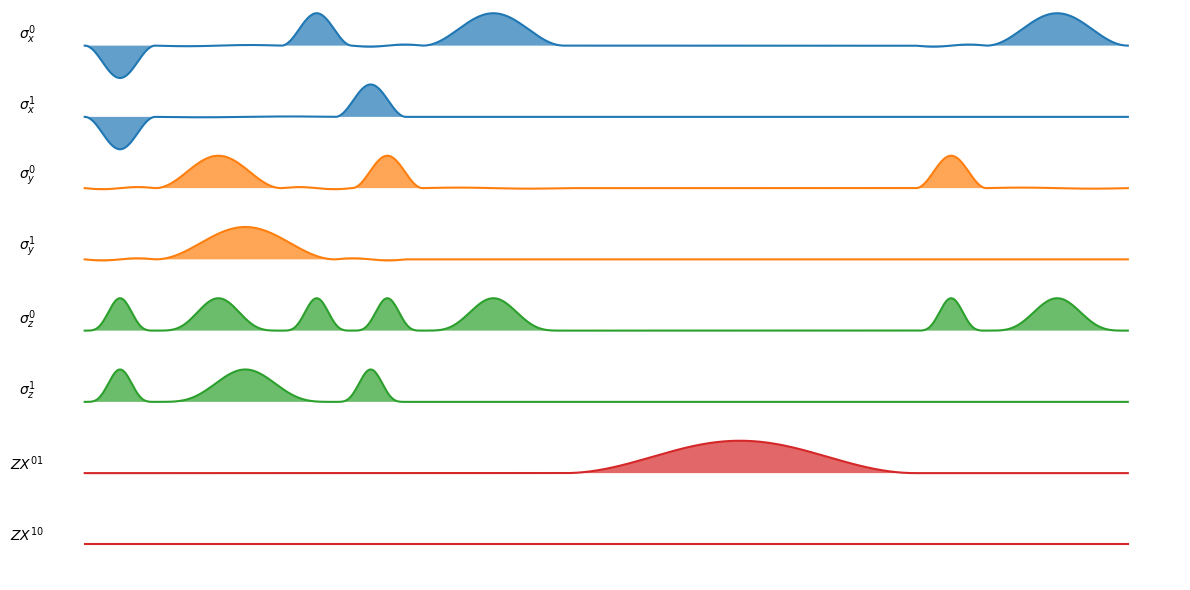

In [11]:
processor.plot_pulses()

### Comparison of Results

To evaluate the quantum simulation, we compare the final results with the standard `sesolve` method.

In [12]:
# Exact Schrodinger equation
tlist = np.linspace(0, tf, 200)
states_sesolve = sesolve(H, init_state, tlist).states

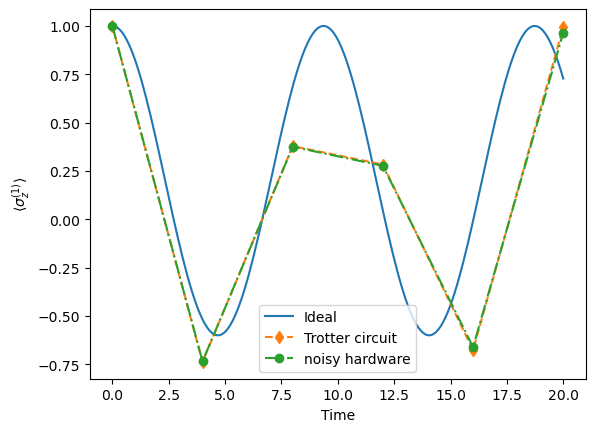

In [13]:
sz_qutrit = basis(3, 0) * basis(3, 0).dag() - basis(3, 1) * basis(3, 1).dag()

expec_sesolve = expect(sz1, states_sesolve)
expec_trotter = expect(sz1, state_trotter_circ)
expec_supcond = expect(sz_qutrit & qeye(3), state_list_proc)

plt.plot(tlist, expec_sesolve, "-", label="Ideal")
plt.plot(times_circ, expec_trotter, "--d", label="Trotter circuit")
plt.plot(times_circ, expec_supcond, "-.o", label="noisy hardware")
plt.xlabel("Time")
plt.ylabel(r"$\langle \sigma_z^{(1)} \rangle$")
plt.legend()
plt.show()

## Lindblad Simulation

To simulate the Lindblad master equation, we consider two recent proposals [\[2, 3\]](#References) where a sequence of unitaries is used to approximate Lindblad dynamics to arbitrary order.
This is realized by employing a ancilla qubits, and measurements / resets, for the Lindblad collapse operators.
The initial state is a dilated state $\ket{\psi_D(t=0)} = \ket{\psi(t = 0)} \otimes \ket{0}^{\otimes K}$ where $K$ referes to the number of ancillas.
Every time step, the system and the ancillas interact for a time span $\sqrt{dt}$.
Thereafter, the ancillas are reset to their ground state.

We can find the Trotter approximation for the unitary describing the interaction between system $i$ and its associated ancilla for collapse operator $k$:

$U(\sqrt{dt}) \approx e^{-\frac{1}{2} i \sigma_{x}^{(i)}\sigma_{x}^{(k)} \sqrt{\gamma_k dt}} \cdot e^{\frac{1}{2} i \sigma_{y}^{(i)}\sigma_{y}^{(k)}\sqrt{\gamma_k dt}}$,

with the dissipation rate $\gamma_k$.
Like in the example above, we can decompose this unitary into Hadamard, `RZ`, `RX` and `RZX` gates which are the native gates for the superconducting processor hardware in QuTiP.

In [14]:
gam = 0.03  # dissipation rate

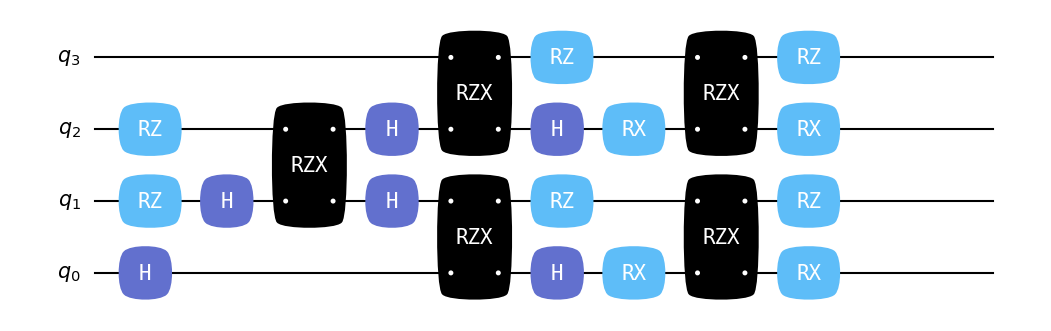

In [15]:
trotter_simulation_noisy = QubitCircuit(4)

sqrt_term = np.sqrt(gam * dt)

# Coherent dynamics
trotter_simulation_noisy.add_gate("RZ", targets=[1], arg_value=epsilon1 * dt)
trotter_simulation_noisy.add_gate("RZ", targets=[2], arg_value=epsilon2 * dt)

trotter_simulation_noisy.add_gate("H", targets=[1])
trotter_simulation_noisy.add_gate("RZX", targets=[1, 2], arg_value=g * dt * 2)
trotter_simulation_noisy.add_gate("H", targets=[1])

# Decoherence
# exp(-i XX t)
trotter_simulation_noisy.add_gate("H", targets=[0])
trotter_simulation_noisy.add_gate("RZX", targets=[0, 1], arg_value=sqrt_term)
trotter_simulation_noisy.add_gate("H", targets=[0])

# exp(-i YY t)
trotter_simulation_noisy.add_gate("RZ", 1, arg_value=np.pi / 2)
trotter_simulation_noisy.add_gate("RX", 0, arg_value=-np.pi / 2)
trotter_simulation_noisy.add_gate("RZX", [0, 1], arg_value=sqrt_term)
trotter_simulation_noisy.add_gate("RZ", 1, arg_value=-np.pi / 2)
trotter_simulation_noisy.add_gate("RX", 0, arg_value=np.pi / 2)

# exp(-i XX t)
trotter_simulation_noisy.add_gate("H", targets=[2])
trotter_simulation_noisy.add_gate("RZX", targets=[2, 3], arg_value=sqrt_term)
trotter_simulation_noisy.add_gate("H", targets=[2])

# exp(-i YY t)
trotter_simulation_noisy.add_gate("RZ", 3, arg_value=np.pi / 2)
trotter_simulation_noisy.add_gate("RX", 2, arg_value=-np.pi / 2)
trotter_simulation_noisy.add_gate("RZX", [2, 3], arg_value=sqrt_term)
trotter_simulation_noisy.add_gate("RZ", 3, arg_value=-np.pi / 2)
trotter_simulation_noisy.add_gate("RX", 2, arg_value=np.pi / 2)

trotter_simulation_noisy.draw("matplotlib")

In [16]:
state_system = ket2dm(init_state)
state_trotter_circ = [init_state]
ancilla = basis(2, 1) * basis(2, 1).dag()
for dd in range(num_steps):
    state_full = tensor(ancilla, state_system, ancilla)
    state_full = trotter_simulation_noisy.run(state=state_full)
    state_system = state_full.ptrace([1, 2])
    state_trotter_circ.append(state_system)

Again, we want to run this trotterized evolution on the superconducting hardware backend. Be aware that, due of the increased complexity, this computation can take several minutes depending on your hardware.

In [17]:
processor = SCQubits(num_qubits=4, t1=3.0e4, t2=3.0e4)
processor.load_circuit(trotter_simulation_noisy)

({'sx1': array([0.0000000e+00, 5.0000000e-01, 1.0000000e+00, ..., 1.4005442e+03,
         1.4010442e+03, 1.4015442e+03], shape=(1361,)),
  'sz1': array([0.0000000e+00, 5.0000000e-01, 1.0000000e+00, ..., 1.4005442e+03,
         1.4010442e+03, 1.4015442e+03], shape=(1361,)),
  'sy1': array([0.0000000e+00, 5.0000000e-01, 1.0000000e+00, ..., 1.4005442e+03,
         1.4010442e+03, 1.4015442e+03], shape=(1361,)),
  'sx2': array([0.00000000e+00, 5.00000000e-01, 1.00000000e+00, 1.50000000e+00,
         2.00000000e+00, 2.50000000e+00, 3.00000000e+00, 3.50000000e+00,
         4.00000000e+00, 4.50000000e+00, 5.00000000e+00, 5.50000000e+00,
         6.00000000e+00, 6.50000000e+00, 7.00000000e+00, 7.50000000e+00,
         8.00000000e+00, 8.50000000e+00, 9.00000000e+00, 9.50000000e+00,
         1.00000000e+01, 1.05000000e+01, 1.10000000e+01, 1.15000000e+01,
         1.20000000e+01, 1.25000000e+01, 1.30000000e+01, 1.35000000e+01,
         1.40000000e+01, 1.45000000e+01, 1.50000000e+01, 1.55000000e+01

In [18]:
state_system = ket2dm(init_state_trit)
state_list_proc = [state_system]
for dd in range(num_steps):
    state_full = tensor(
        basis(3, 1) * basis(3, 1).dag(),
        state_system,
        basis(3, 1) * basis(3, 1).dag(),
    )
    result_noisey = processor.run_state(
        state_full,
        solver="mesolve",
        options={
            "store_states": False,
            "store_final_state": True,
        },
    )
    state_full = result_noisey.final_state
    state_system = state_full.ptrace([1, 2])
    state_list_proc.append(state_system)
    print(f"Step {dd+1}/{num_steps} finished.")

Step 1/5 finished.


Step 2/5 finished.


Step 3/5 finished.


Step 4/5 finished.


Step 5/5 finished.


(<Figure size 1200x600 with 18 Axes>,
 [<Axes: ylabel='$\\sigma_x^0$'>,
  <Axes: ylabel='$\\sigma_x^1$'>,
  <Axes: ylabel='$\\sigma_x^2$'>,
  <Axes: ylabel='$\\sigma_x^3$'>,
  <Axes: ylabel='$\\sigma_y^0$'>,
  <Axes: ylabel='$\\sigma_y^1$'>,
  <Axes: ylabel='$\\sigma_y^2$'>,
  <Axes: ylabel='$\\sigma_y^3$'>,
  <Axes: ylabel='$\\sigma_z^0$'>,
  <Axes: ylabel='$\\sigma_z^1$'>,
  <Axes: ylabel='$\\sigma_z^2$'>,
  <Axes: ylabel='$\\sigma_z^3$'>,
  <Axes: ylabel='$ZX^{01}$'>,
  <Axes: ylabel='$ZX^{10}$'>,
  <Axes: ylabel='$ZX^{12}$'>,
  <Axes: ylabel='$ZX^{21}$'>,
  <Axes: ylabel='$ZX^{23}$'>,
  <Axes: ylabel='$ZX^{32}$'>])

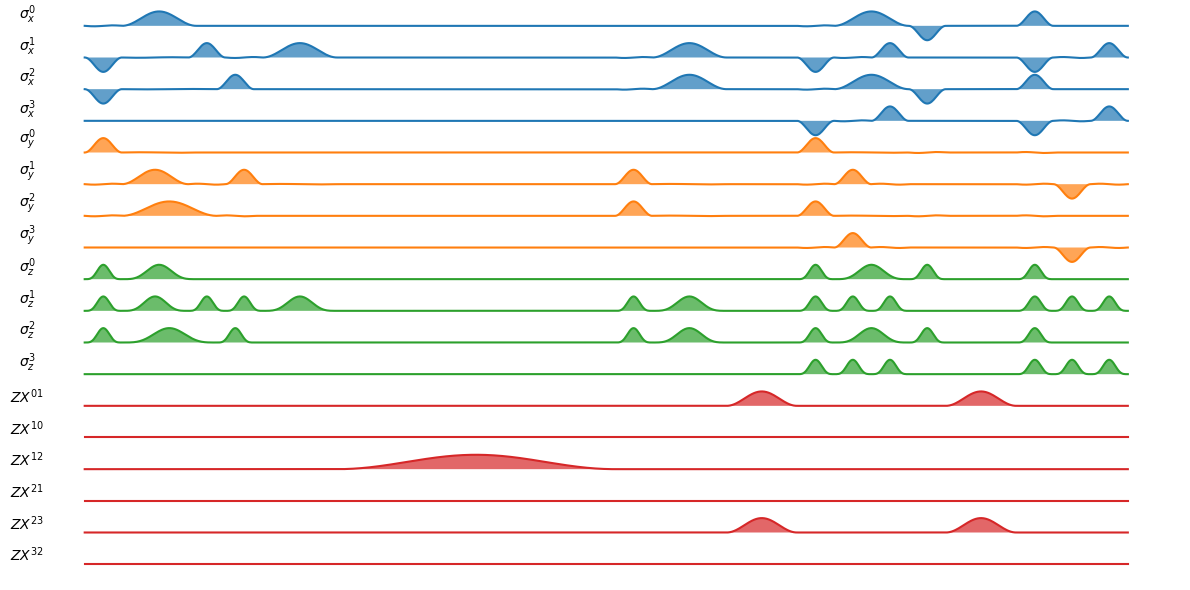

In [19]:
processor.plot_pulses()

### Comparison of Results

In [20]:
# Standard mesolve solution
sm1 = tensor(destroy(2).dag(), qeye(2))
sm2 = tensor(qeye(2), destroy(2).dag())
c_ops = [np.sqrt(gam) * sm1, np.sqrt(gam) * sm2]

result_me = mesolve(H, init_state, tlist, c_ops, e_ops=[sz1, sz2])

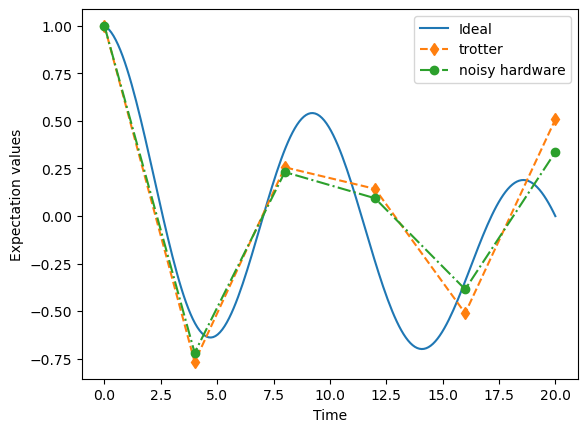

In [21]:
expec_mesolve = result_me.expect[0]
expec_trotter = expect(sz1, state_trotter_circ)
expec_supcond = expect(sz_qutrit & qeye(3), state_list_proc)

plt.plot(tlist, expec_mesolve, "-", label=r"Ideal")
plt.plot(times_circ, expec_trotter, "--d", label="trotter")
plt.plot(times_circ, expec_supcond, "-.o", label=r"noisy hardware")
plt.xlabel("Time")
plt.ylabel("Expectation values")
plt.legend()
plt.show()

## References

\[1\] [Li, et. al, Quantum (2022)](http://dx.doi.org/10.22331/q-2022-01-24-630)

\[2\] [Ding, et. al, PRX Quantum (2024)](https://doi.org/10.1103/PRXQuantum.5.020332)

\[3\] [Cleve and Lang, ICALP (2017)](https://doi.org/10.48550/arXiv.1612.09512)

\[4\] [QuTiP 5: The Quantum Toolbox in Python](https://arxiv.org/abs/2412.04705)

## About

In [22]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


### Testing

In [23]:
np.testing.assert_allclose(expec_trotter, expec_supcond, atol=0.22)

tc1 = np.abs(tlist - times_circ[1]).argmin()
tc2 = np.abs(tlist - times_circ[2]).argmin()
np.testing.assert_allclose([expec_mesolve[tc1]], [expec_trotter[1]], atol=0.2, rtol=0.3)
np.testing.assert_allclose([expec_mesolve[tc1]], [expec_supcond[1]], atol=0.2, rtol=0.3)
np.testing.assert_allclose([expec_mesolve[tc2]], [expec_trotter[2]], atol=0.2, rtol=0.3)
np.testing.assert_allclose([expec_mesolve[tc2]], [expec_supcond[2]], atol=0.2, rtol=0.3)